# AAAAAAAAAAAAA

## O ONIICHANN DAISUKIII

## BAJKAAAAA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import make_scorer, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.preprocessing import RobustScaler, OneHotEncoder, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
import imblearn
from imblearn.over_sampling import SMOTE
pd.set_option('display.max_columns', None)

import joblib

https://www.kaggle.com/volodymyrgavrysh/bank-marketing-campaigns-dataset

__Conducted campaigns were based mostly on direct phone calls, offering bank client to place a term deposit.
If after all marking afforts client had agreed to place deposit - target variable marked 'yes', otherwise 'no'__

# Feature Desc

### bank client data:

1. age
    - (numeric)

2. job : type of job 
    - (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")

3. marital : marital status 
    - (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)

4. education 
    - (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")

5. default: has credit in default? (lalai bayar (?))
    - (categorical: "no","yes","unknown")

6. housing: has housing loan? 
    - (categorical: "no","yes","unknown")

7. loan: has personal loan?
    - (categorical: "no","yes","unknown")
    
### related with the last contact of the current campaign:
8. contact: contact communication type
    - (categorical: "cellular","telephone")
9. month: last contact month of year
    - (categorical: "jan", "feb", "mar", …, "nov", "dec")

10. dayofweek: last contact day of the week
    - (categorical: "mon","tue","wed","thu","fri")

11. duration: last contact duration, in seconds (numeric). ==> (obvious feature (?))
    - __Important note__: this attribute highly affects the output target (e.g., if duration=0 then y="no"). 
    - Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

### other attributes:
12. campaign: number of contacts performed during this campaign and for this client 
    - (numeric, includes last contact)

13. pdays: number of days that passed by after the client was last contacted from a previous campaign
    - (numeric; 999 means client was not previously contacted)

14. previous: number of contacts performed before this campaign and for this client
    - (numeric)

15. poutcome: outcome of the previous marketing campaign 
    - (categorical: "failure","nonexistent","success")

### social and economic context attributes
16. emp.var.rate: employment variation rate - quarterly indicator (???)
    - (numeric)

17. cons.price.idx: consumer price index - monthly indicator
    - changes in the price level of a weighted average __market basket__ of consumer goods and services purchased by households
    - affect inflation
    - (numeric)

18. cons.conf.idx: consumer confidence index - monthly indicator
    - degree of __consumers optimism__ are expressing through their activities of savings and spending.
    - affect consumer behavior
    - (numeric)

19. euribor3m: euribor 3 month rate - daily indicator
    - Euribor (euro interbank offered rate)
    - ??
    - (numeric)

20. nr.employed: number of employees - quarterly indicator
    - Number of employed persons for a quarter. (for the bank ??)
    - (numeric)

### Output variable (desired target):

21. y - has the client subscribed a term deposit?
    - (binary: "yes","no")

In [2]:
df = pd.read_csv('bank-additional-full.csv', sep=';')
df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  duration  campaign  pdays  previous     poutcome  \
0   may         mon       261         1    999         0  nonexistent   
1   may         mon       149         1    999         0  nonexistent   
2   may         mon       226         1    999         0  nonexistent   
3   may         mon       151         1    999         0  nonexistent   
4   may         mon       307         1    999         0  nonexistent   

   emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0           1.1          93.994          -36.4      4.857       5191.0  no  
1           1.1          93.994          -36.4      4.857       5191.0  no  
2           1.1          93.994          -36.4      4.857       5191.0  no  
3           1.1          93.994          -36.4      4.857       5191.0  no  
4           1.1          93.994          -36.4      4.857       5191.0  no

In [3]:
df.education = df.education.apply(lambda x : x.replace(".", " "))

# Data Description

In [4]:
dfDesc = []
for i in df.columns:
    if df[i].nunique() > 3 :
        bla = df[i].drop_duplicates().sample(3).values
    else :
        bla = df[i].drop_duplicates().values
    
    dfDesc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round((((df[i].isna().sum()) / len(df)) * 100), 2),
        df[i].nunique(),
        bla
    ])
    
pd.DataFrame(dfDesc, columns=[
    "Data Features",
    "Data Types",
    "Null",
    "Null Percentage",
    "Unique",
    "Unique Sample"
])

Data Features Data Types  Null  Null Percentage  Unique  \
0              age      int64     0              0.0      78   
1              job     object     0              0.0      12   
2          marital     object     0              0.0       4   
3        education     object     0              0.0       8   
4          default     object     0              0.0       3   
5          housing     object     0              0.0       3   
6             loan     object     0              0.0       3   
7          contact     object     0              0.0       2   
8            month     object     0              0.0      10   
9      day_of_week     object     0              0.0       5   
10        duration      int64     0              0.0    1544   
11        campaign      int64     0              0.0      42   
12           pdays      int64     0              0.0      27   
13        previous      int64     0              0.0       8   
14        poutcome     object     0              0.0       3   
15    emp.var.rate    float64     0              0.0      10   
16  cons.price.idx    float64     0              0.0      26   
17   cons.conf.idx    float64     0              0.0      26   
18       euribor3m    float64     0              0.0     316   
19     nr.employed    float64     0              0.0      11   
20               y     object     0              0.0       2   

                                      Unique Sample  
0                                      [53, 47, 43]  
1                [housemaid, services, blue-collar]  
2                      [married, unknown, divorced]  
3         [professional course, basic 4y, basic 6y]  
4                                [no, unknown, yes]  
5                                [no, yes, unknown]  
6                                [no, yes, unknown]  
7                             [telephone, cellular]  
8                                   [dec, mar, may]  
9                                   [wed, mon, thu]  
10                                  [683, 853, 574]  
11                                      [19, 24, 3]  
12                                       [1, 7, 16]  
13                                        [0, 5, 3]  
14                  [nonexistent, failure, success]  
15                               [-1.7, -2.9, -3.0]  
16              [93.876, 93.91799999999999, 94.215]  
17                            [-45.9, -40.8, -36.4]  
18  [0.8540000000000001, 1.262, 0.9420000000000001]  
19                         [5076.2, 5176.3, 5099.1]  
20                                        [no, yes]

__Insisght__:
- Tidak ada data null

# Stats Description

In [5]:
df.describe().T

count         mean         std       min       25%  \
age             41188.0    40.024060   10.421250    17.000    32.000   
duration        41188.0   258.285010  259.279249     0.000   102.000   
campaign        41188.0     2.567593    2.770014     1.000     1.000   
pdays           41188.0   962.475454  186.910907     0.000   999.000   
previous        41188.0     0.172963    0.494901     0.000     0.000   
emp.var.rate    41188.0     0.081886    1.570960    -3.400    -1.800   
cons.price.idx  41188.0    93.575664    0.578840    92.201    93.075   
cons.conf.idx   41188.0   -40.502600    4.628198   -50.800   -42.700   
euribor3m       41188.0     3.621291    1.734447     0.634     1.344   
nr.employed     41188.0  5167.035911   72.251528  4963.600  5099.100   

                     50%       75%       max  
age               38.000    47.000    98.000  
duration         180.000   319.000  4918.000  
campaign           2.000     3.000    56.000  
pdays            999.000   999.000   999.000  
previous           0.000     0.000     7.000  
emp.var.rate       1.100     1.400     1.400  
cons.price.idx    93.749    93.994    94.767  
cons.conf.idx    -41.800   -36.400   -26.900  
euribor3m          4.857     4.961     5.045  
nr.employed     5191.000  5228.100  5228.100

In [6]:
df.describe(include='O')

job  marital          education default housing   loan   contact  \
count    41188    41188              41188   41188   41188  41188     41188   
unique      12        4                  8       3       3      3         2   
top     admin.  married  university degree      no     yes     no  cellular   
freq     10422    24928              12168   32588   21576  33950     26144   

        month day_of_week     poutcome      y  
count   41188       41188        41188  41188  
unique     10           5            3      2  
top       may         thu  nonexistent     no  
freq    13769        8623        35563  36548

# Cek Imbalance Data dan Pembagian data numerik dan kategorik

In [7]:
df['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

In [8]:
num=['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
cat=[i for i in df.columns if i not in num]

# Cek Outliers

In [9]:
Desc_outliers = []

for i in df.describe().columns:
    Q1 = df.describe()[i]['25%']
    Q3 = df.describe()[i]['75%']
    IQR = Q3 - Q1
    upper_fence = Q3 + (1.5*IQR)
    lower_fence = Q1 - (1.5*IQR)
    hitung = 0
    
    for j in df[i]:
        if (j < lower_fence) | (j > upper_fence) :
            hitung+=1
    Desc_outliers.append([
        i,
        hitung,
        upper_fence,
        lower_fence
    ])

out = pd.DataFrame(Desc_outliers, columns=[
    "Data Features",
    "Jumlah Outliers",
    "Upper Fence",
    "Lower Fence"
])
out

Data Features  Jumlah Outliers  Upper Fence  Lower Fence
0             age              469      69.5000       9.5000
1        duration             2963     644.5000    -223.5000
2        campaign             2406       6.0000      -2.0000
3           pdays             1515     999.0000     999.0000
4        previous             5625       0.0000       0.0000
5    emp.var.rate                0       6.2000      -6.6000
6  cons.price.idx                0      95.3725      91.6965
7   cons.conf.idx              447     -26.9500     -52.1500
8       euribor3m                0      10.3865      -4.0815
9     nr.employed                0    5421.6000    4905.6000

__Insight__:

- Pd kolom age, duration, campaign, pdays, previous dan cons.conf.idx memiliki outliers yg cukup banyak

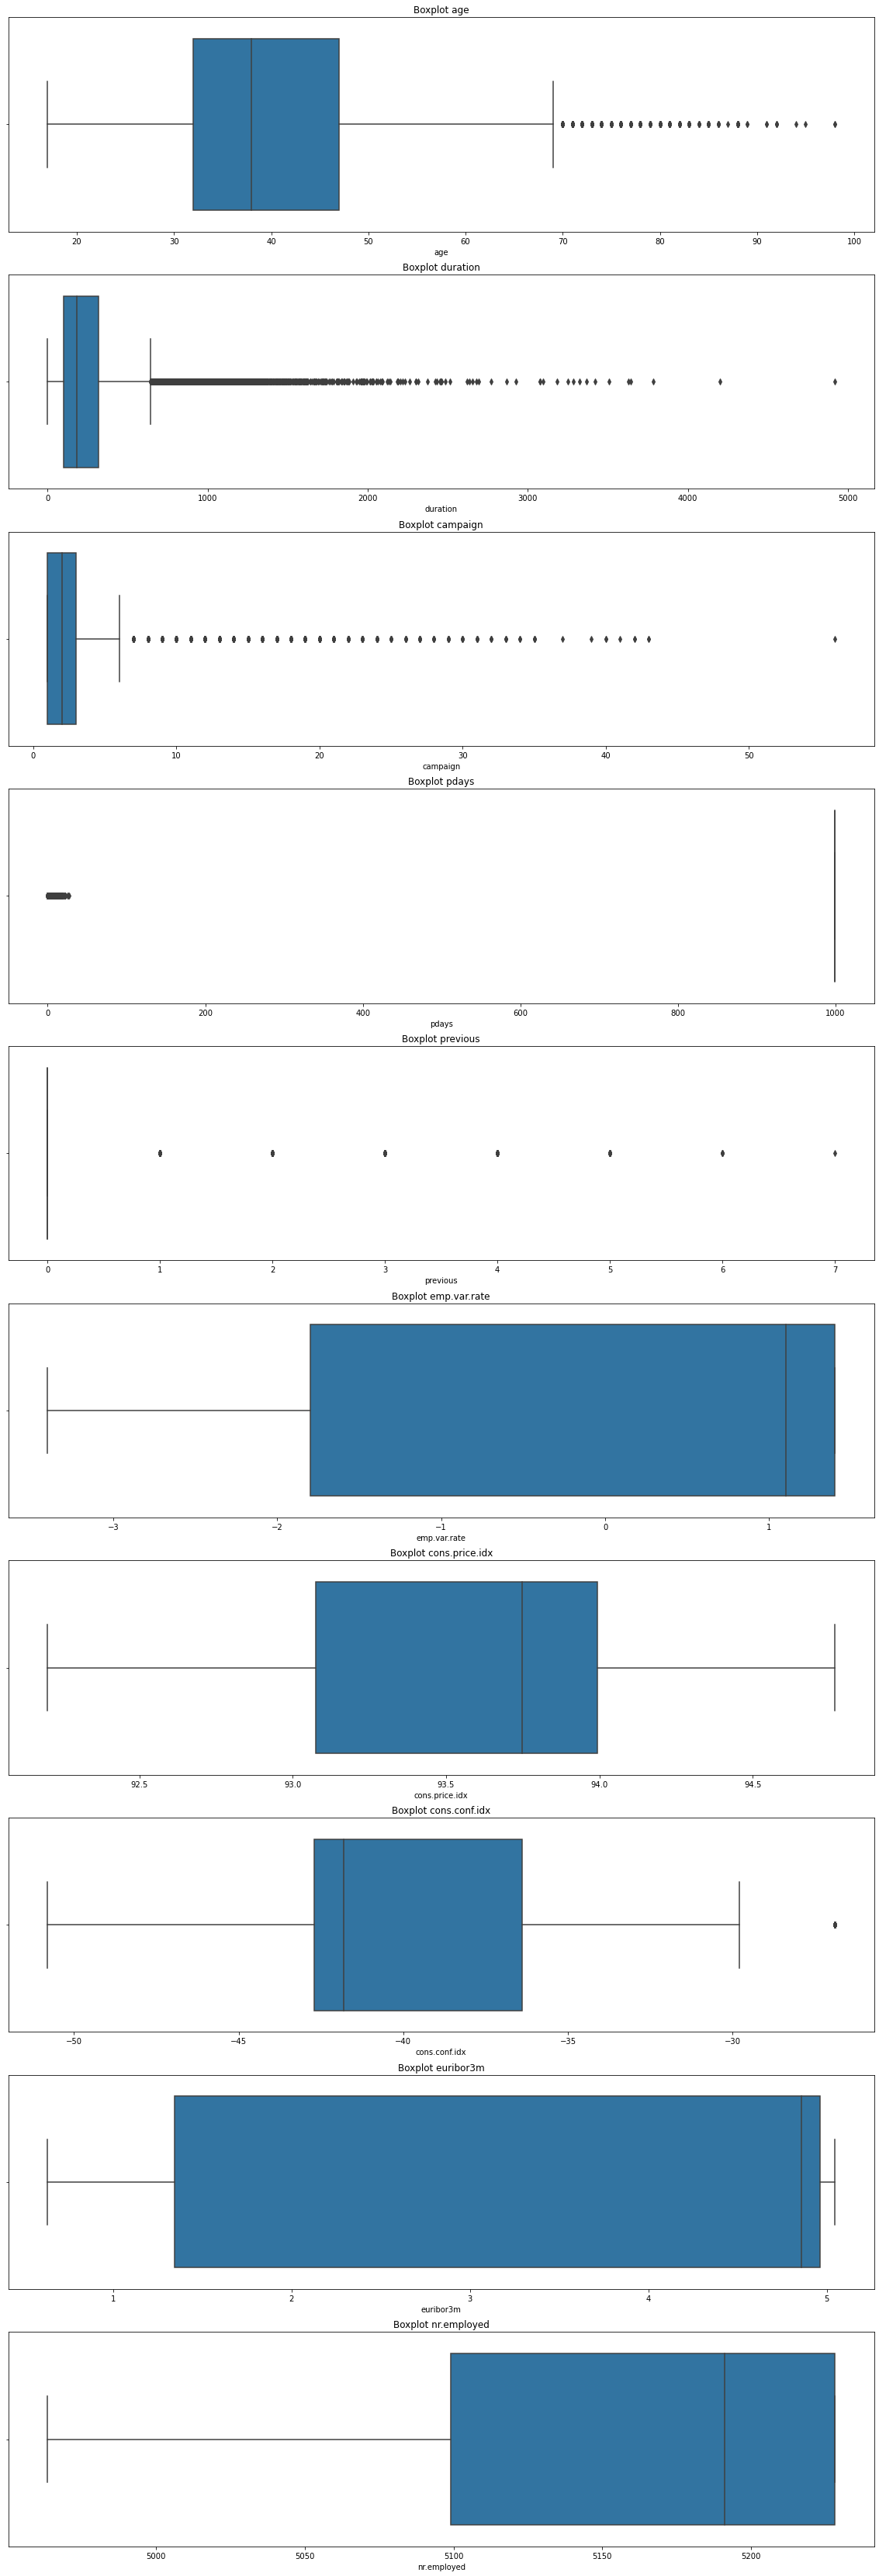

In [10]:
plt.figure(figsize=(20,60))
tes = 1

for i in df.describe().columns:
    plt.subplot(10, 1, tes)
    sns.boxplot(x=df[i])
    plt.title('Boxplot ' + i)
    tes += 1

In [11]:
df['previous'].value_counts()

0    35563
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: previous, dtype: int64

__Insight__:

- Pd kolom pdays bentuk boxplotnya unik karena nilai 999 nya sangat lebih banyak dari nilai lainnya memiliki rentang yang jauh dengan 999
- Pd kolom previous bentuk boxplotnya unik karena nilai 0 nya sangat lebih banyak dari niali lainnya. antar nilai memiliki rentang 1. 

# EXPLANATORY DATA ANALYSIS

melakukan 2 tipe analisis yaitu Univariate dan Multi Variate

## Univariate

- untuk data numerical continues menggunakan histogram untuk melihat distribusi nilai
- untuk data categorical menggunakan barplot

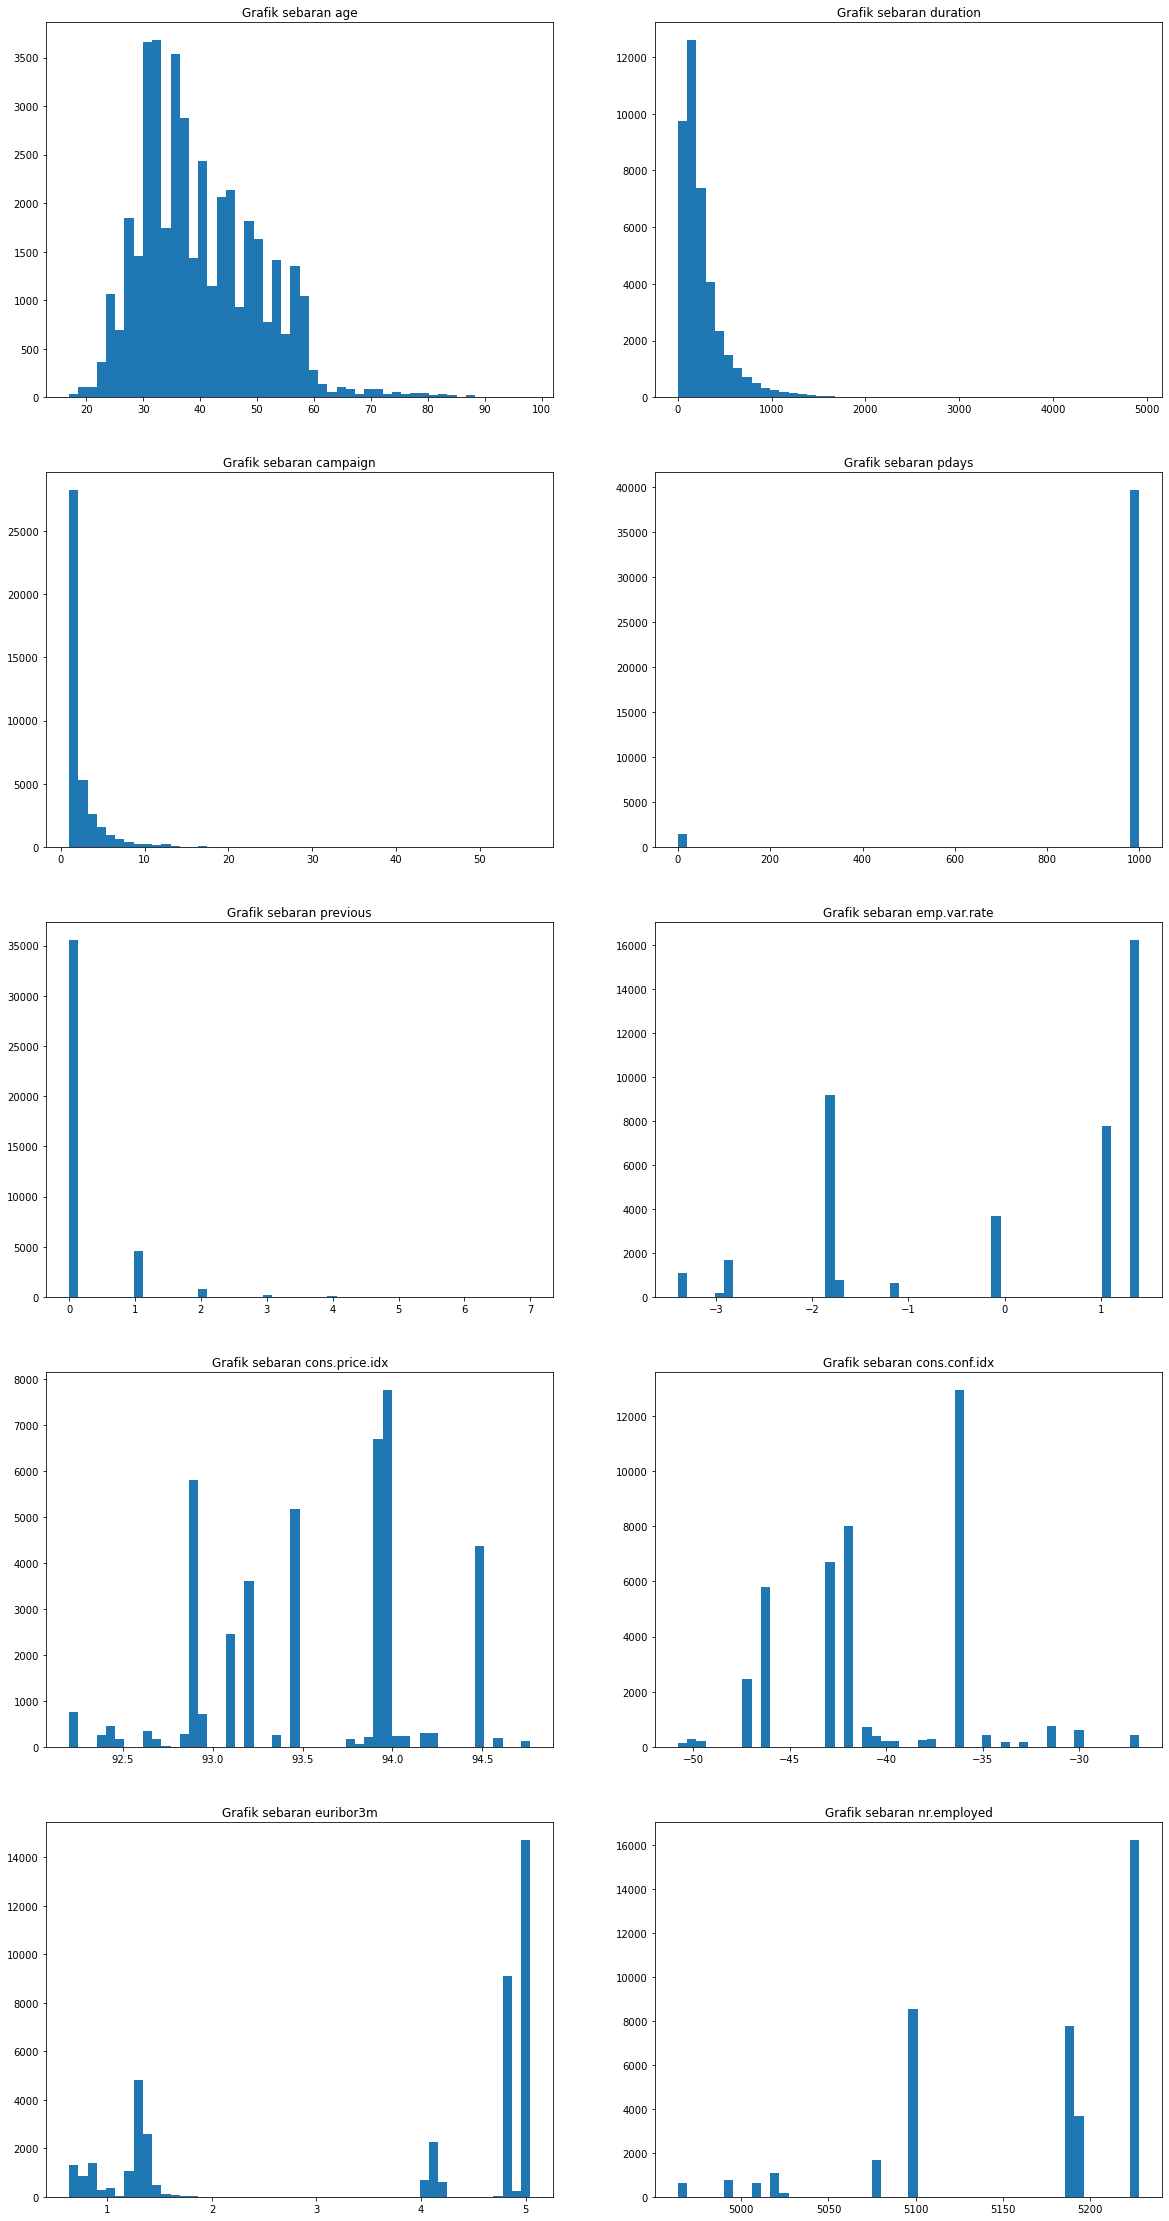

In [90]:
# plotting numerical continues features in histogram

plt.figure(figsize=(20,40))

for i in num:
    plt.subplot(5,2,(num.index(i))+1)
    plt.hist(df[i], bins=50)
    plt.title('Grafik sebaran '+ i)

In [13]:
# def function for table univariate categorical

def tab_cat (x):
    table = pd.crosstab(index = df[x], columns = 'Jumlah')
    return table

In [14]:
tab_cat(cat[1])

col_0     Jumlah
marital         
divorced    4612
married    24928
single     11568
unknown       80

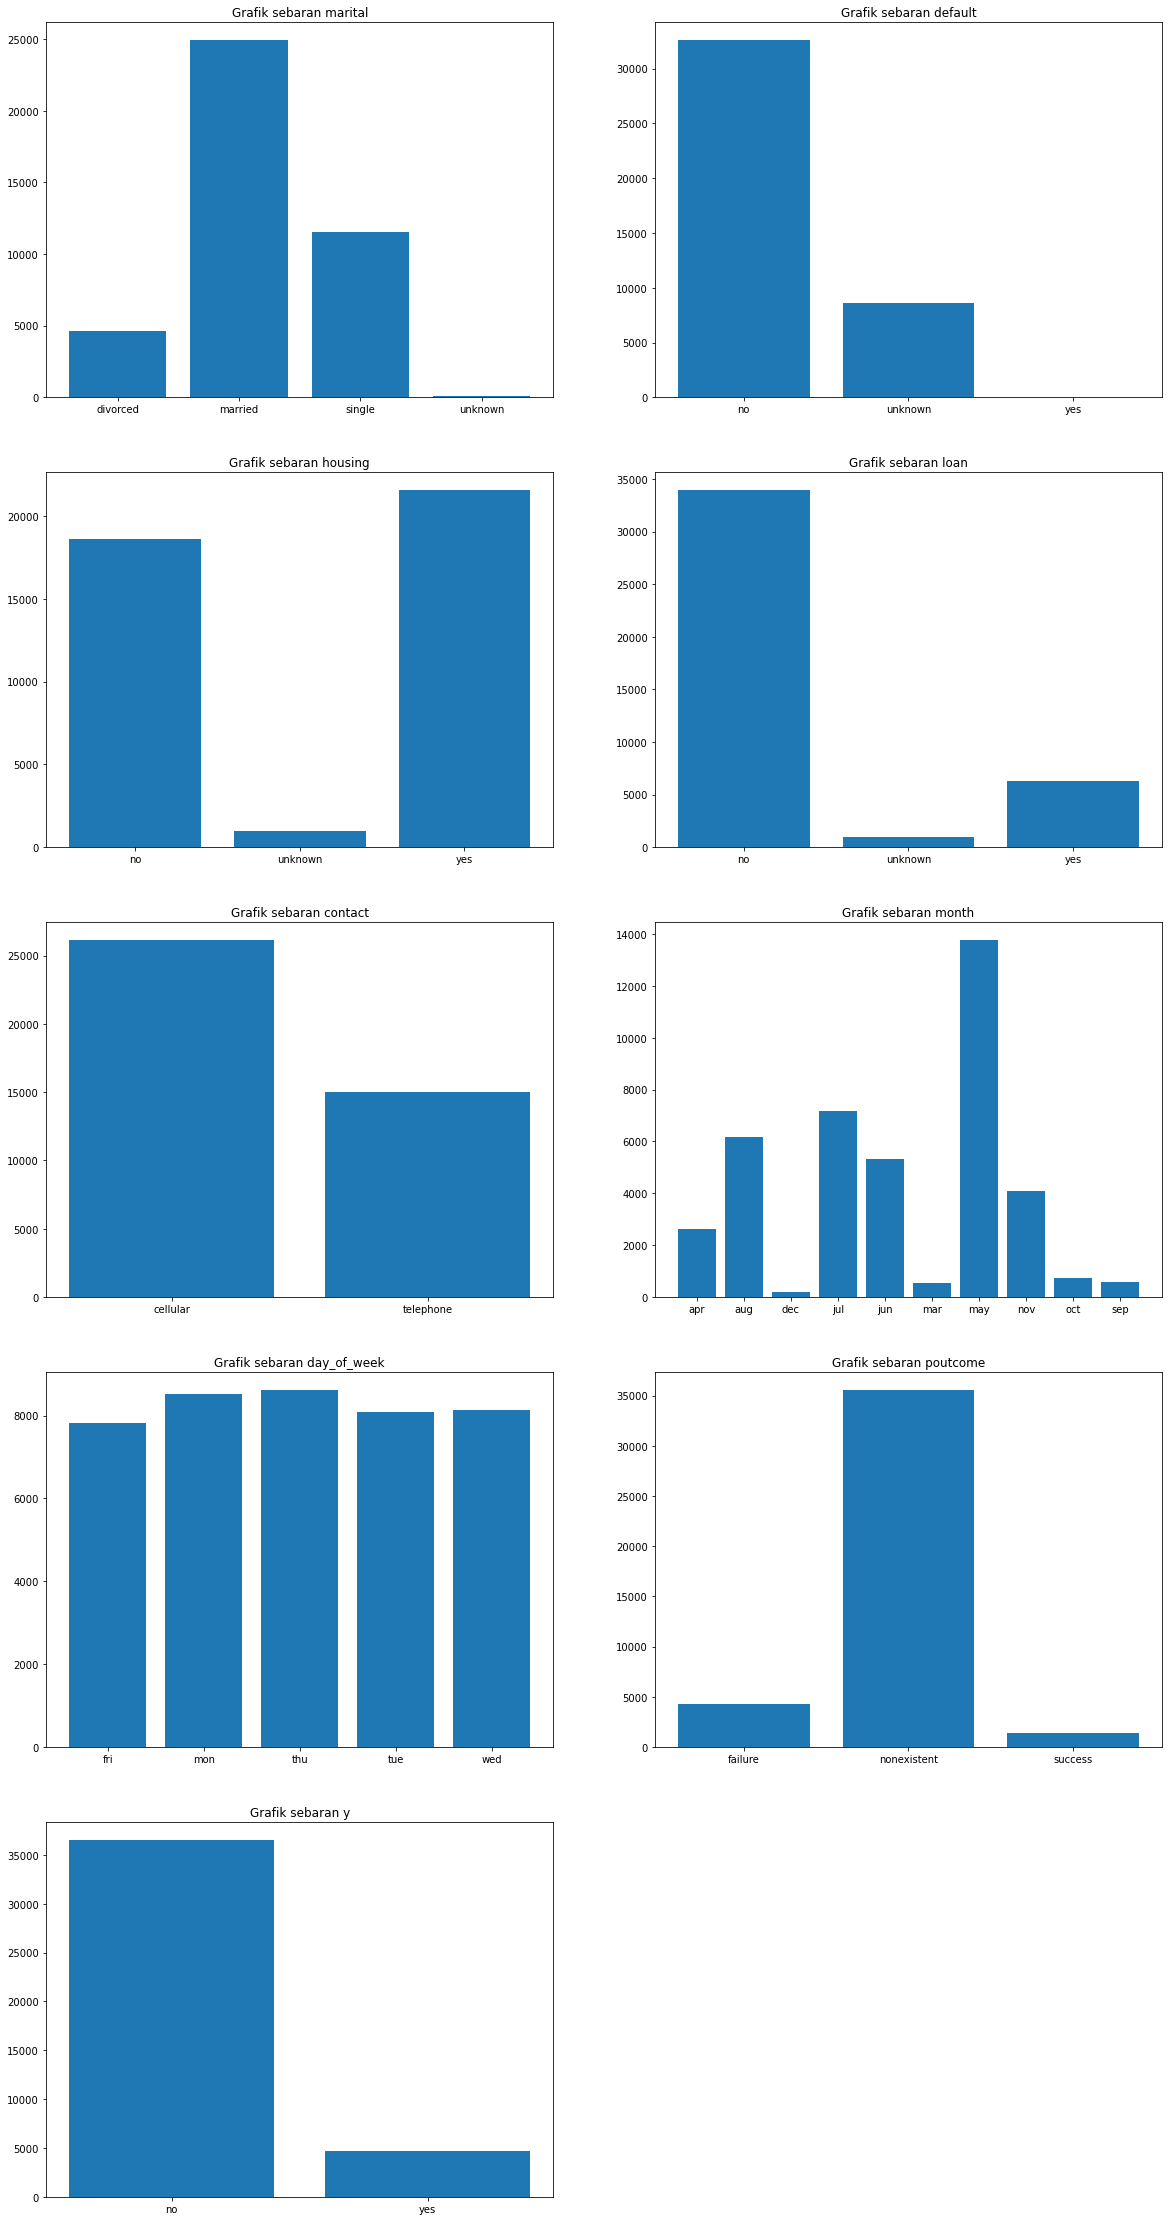

In [15]:
# plotting distribution of categorical features in barplot

plt.figure(figsize=(20,40))

tes = 1
for i in cat:
    if (i != 'job') & (i != 'education'):
        plt.subplot(5,2,tes)
        table_cat = pd.crosstab(index = df[i], columns = 'Jumlah')
        table_cat =  table_cat.reset_index()
        table_cat[i] = table_cat[i].astype('str')
        plt.bar(table_cat[i], table_cat['Jumlah'])
        plt.title('Grafik sebaran '+ i)
        tes +=1

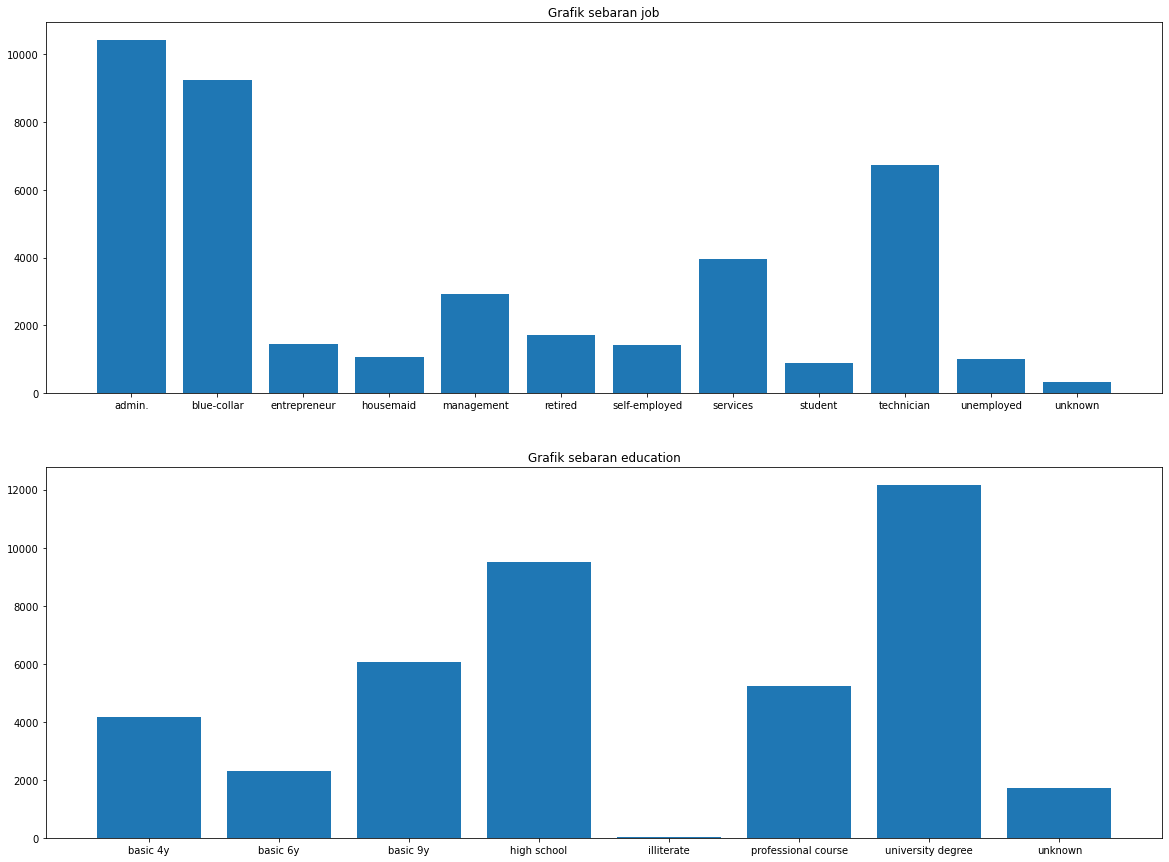

In [16]:
plt.figure(figsize=(20,15))

tes = 1
for i in ['job', 'education']:
    plt.subplot(2,1,tes)
    table_cat = pd.crosstab(index = df[i], columns = 'Jumlah')
    table_cat =  table_cat.reset_index()
    table_cat[i] = table_cat[i].astype('str')
    plt.bar(table_cat[i], table_cat['Jumlah'])
    plt.title('Grafik sebaran '+ i)
    tes +=1

## Multivariate

1. Hubungn tiap variabel dengan targetnya

2. Tambhan lainnya"

#### __1. HUBUNGAN TIAP VARIABLE DENGAN KOLOM TARGET__

__- Kolom numerical dengan kolom target__

In [17]:
# def fucntion for table y (subscribed for deposit or not) in response to Numerical features

def table_num_y (x):
    tabel = pd.pivot_table(df, values=x, index='y', aggfunc=np.mean).round(2)
    tabel.rename(columns={x:'Rata-rata '+x + ' di masing2 y nya'}, inplace=True)
    return tabel

In [18]:
table_num_y(num[1])

Rata-rata duration di masing2 y nya
y                                       
no                                220.84
yes                               553.19

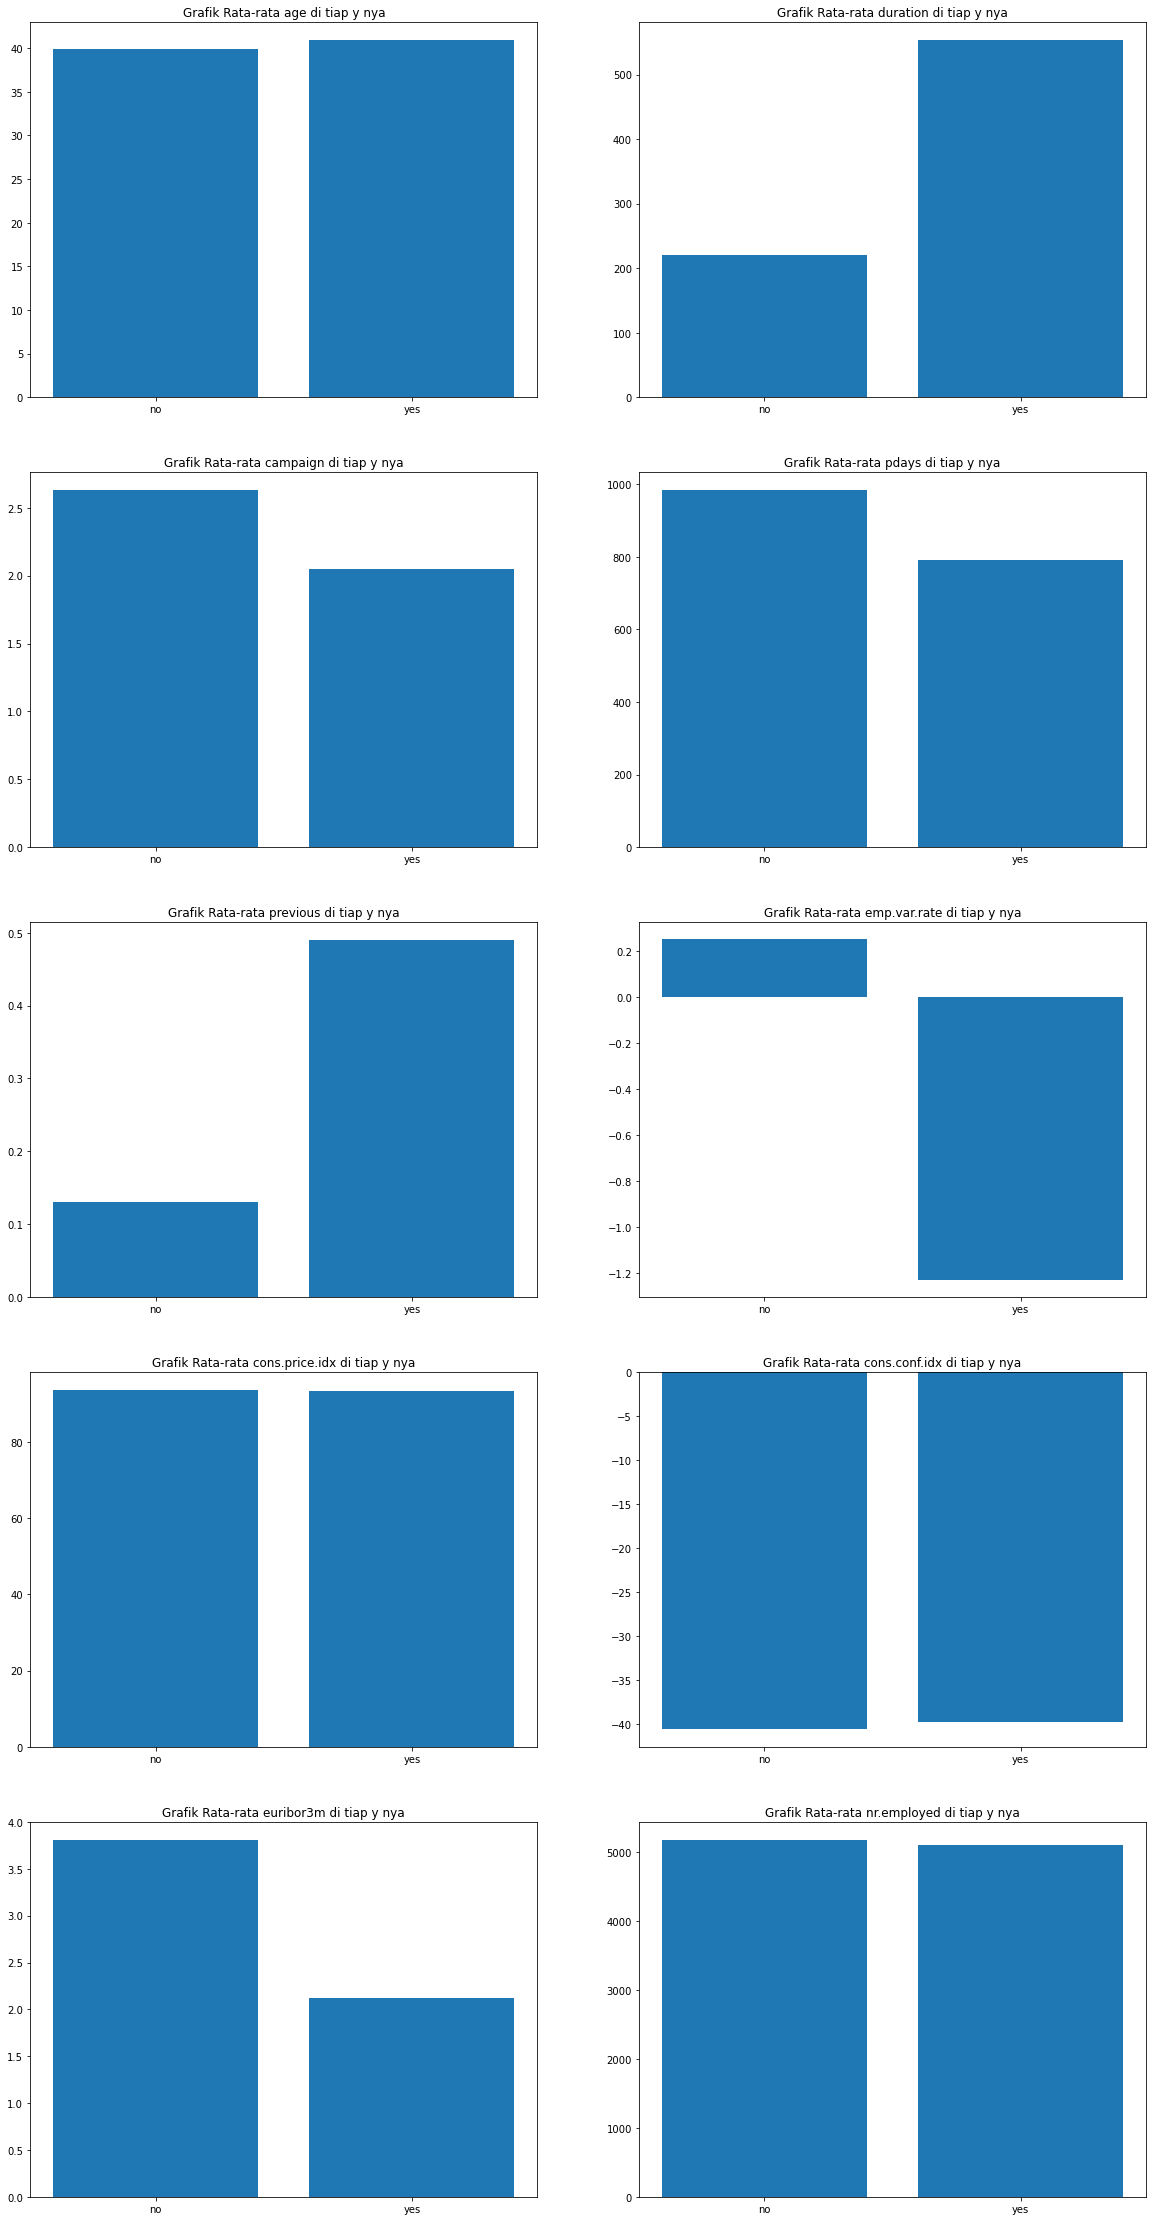

In [19]:
plt.figure(figsize=(20,40))

for i in num:
    bla = pd.pivot_table(df, values=i, index='y', aggfunc=np.mean).round(2)
    bla = bla.reset_index()
    bla['y'] = bla['y'].astype('str')
    plt.subplot(5,2,(num.index(i) + 1))
    plt.bar(bla['y'], bla[i])
    plt.title("Grafik Rata-rata " + i + " di tiap y nya")

__- Kolom categorical dengan kolom target__

In [20]:
# def fucntion table y (subscribed for deposit or not) in response to Categorical features

def table_cat_y (x):
    table = pd.crosstab(index=[df['y'], df[x]], columns='Jumlah')
    persen = []
    
    if x == 'default':
        for i in (table.reset_index()['y']).unique():
            if i == 'yes' :
                for j in ['no', 'unknown']:
                    persen.append(
                        round((table.loc[i,j][0]/(table.loc[i]).sum()[0])*100, 2)
                    )
            elif i == 'no' :
                for k in (table.reset_index()[x]).unique():
                    persen.append(
                        round((table.loc[i,k][0]/(table.loc[i]).sum()[0])*100, 2)
                    )
    else :
        for a in (table.reset_index()['y']).unique():
            for b in (table.reset_index()[x]).unique():
                persen.append(
                    round((table.loc[a,b][0]/(table.loc[a]).sum()[0])*100, 2)
                )
    table['Persentase tiap y(%)'] = persen
    return table

In [21]:
table_cat_y(cat[3])

col_0        Jumlah  Persentase tiap y(%)
y   default                              
no  no        28391                 77.68
    unknown    8154                 22.31
    yes           3                  0.01
yes no         4197                 90.45
    unknown     443                  9.55

In [22]:
cat_2 = [i for i in cat if (i != 'y') & (i != 'job') & (i != 'education')]
cat_3 = [i for i in cat if (i != 'y') & (i not in cat_2)]

In [23]:
cat_2

['marital',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [24]:
cat_3

['job', 'education']

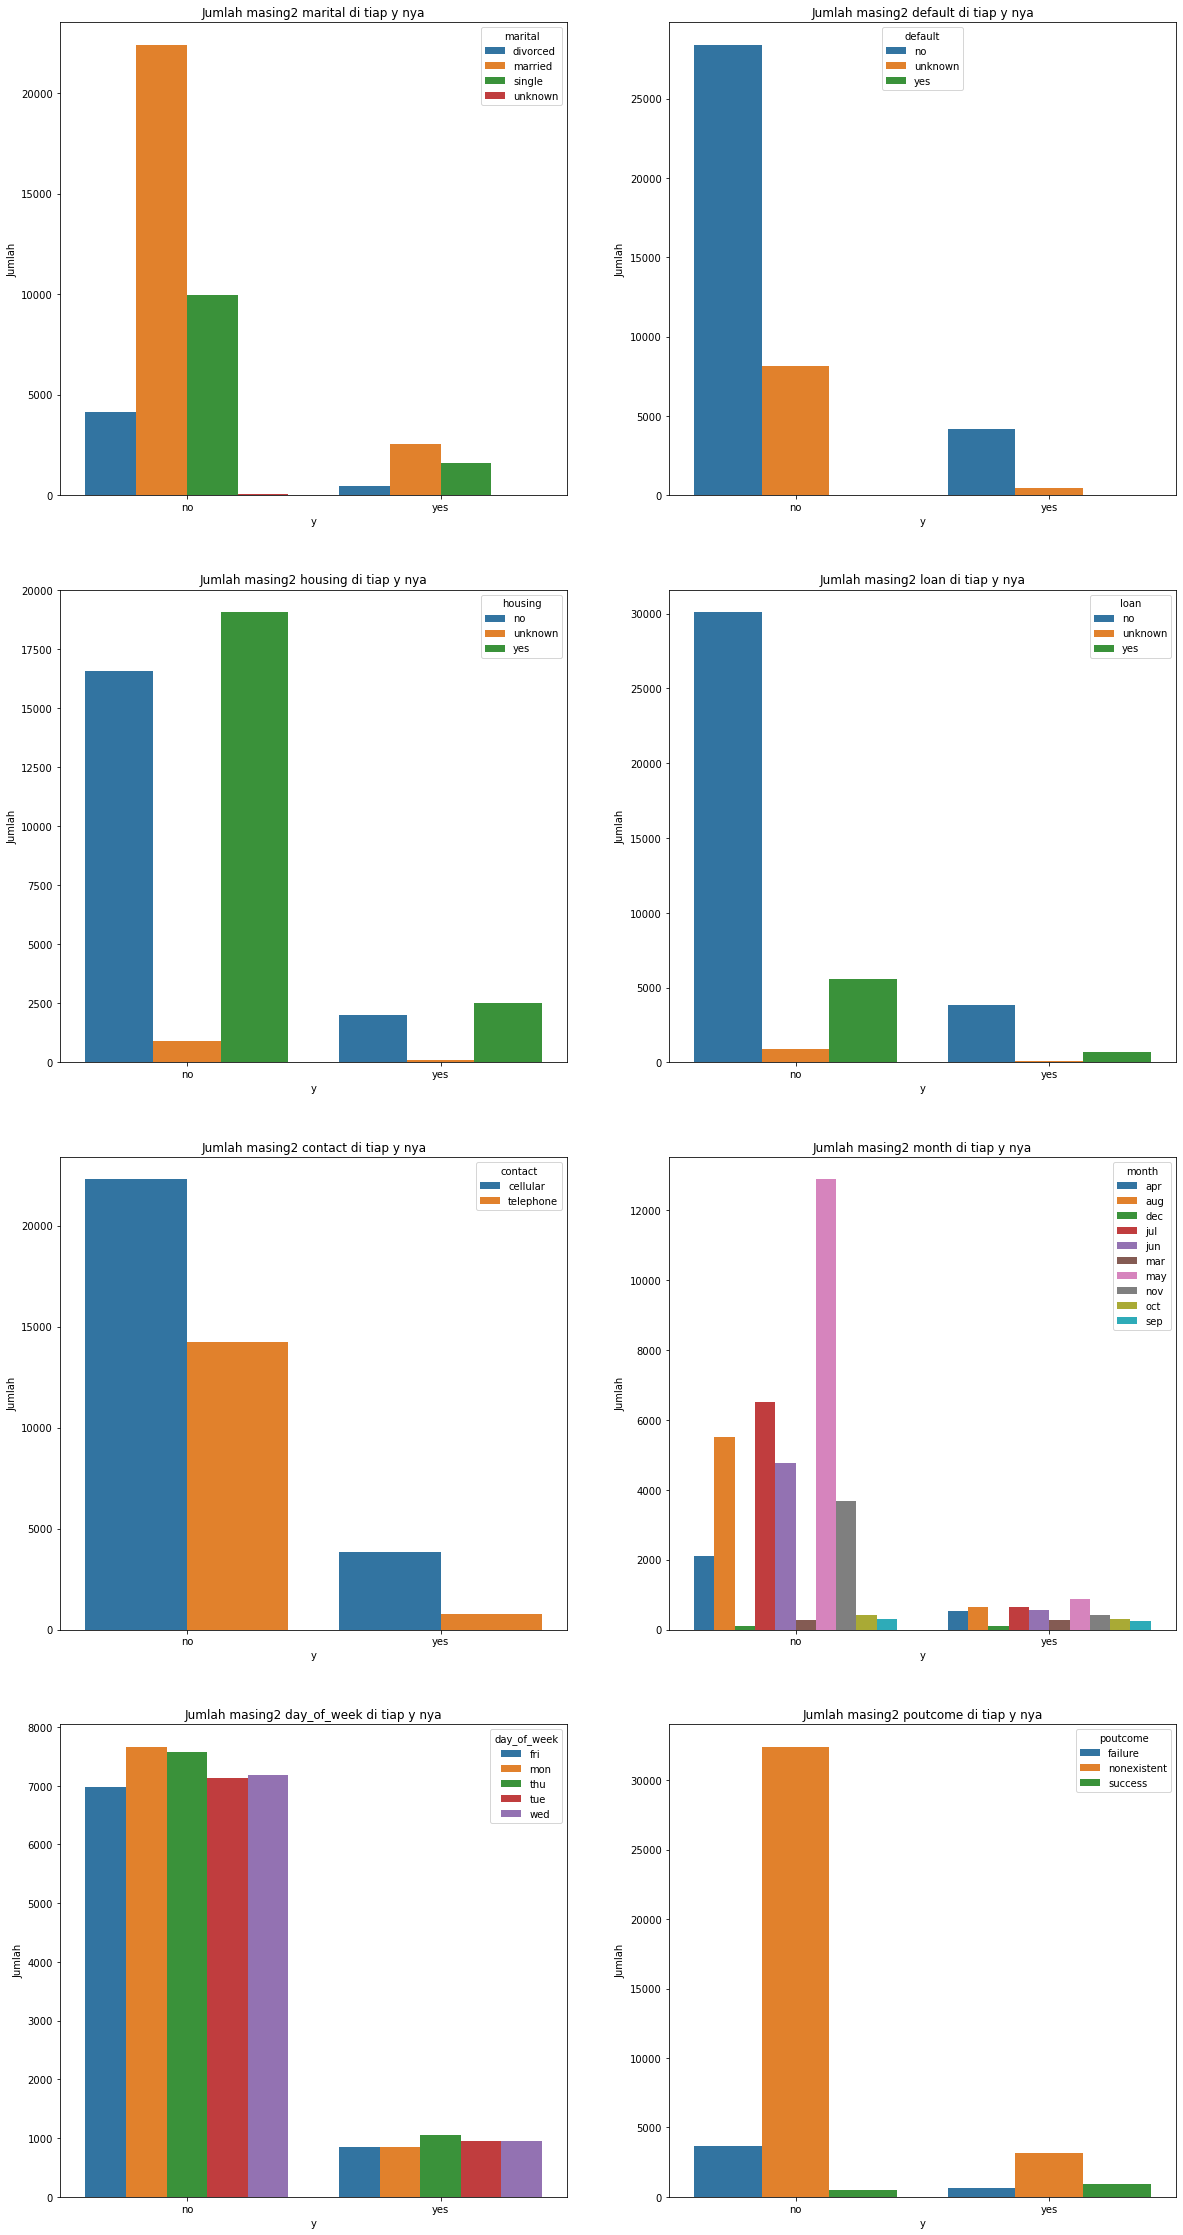

In [25]:
fig, axes = plt.subplots(4, 2, figsize=(20, 40))
for i in cat_2: 
    bla2 = pd.crosstab(index=[df['y'], df[i]], columns='Jumlah')
    bla2 = bla2.reset_index()

    if cat_2.index(i) < 2:
        sns.barplot(ax = axes[0,cat_2.index(i)], x='y', y='Jumlah', data = bla2, hue=i)
        axes[0,(cat_2.index(i))].set_title('Jumlah masing2 ' + i + ' di tiap y nya')
    elif 2 <= cat_2.index(i) < 4:
        sns.barplot(ax = axes[1,(cat_2.index(i) - 2)], x='y', y='Jumlah', data = bla2, hue=i)
        axes[1,(cat_2.index(i)-2)].set_title('Jumlah masing2 ' + i + ' di tiap y nya')
    elif 4 <= cat_2.index(i) < 6:
        sns.barplot(ax = axes[2,(cat_2.index(i) - 4)], x='y', y='Jumlah', data = bla2, hue=i)
        axes[2,(cat_2.index(i)-4)].set_title('Jumlah masing2 ' + i + ' di tiap y nya')
    elif 6 <= cat_2.index(i) < 8:
        sns.barplot(ax = axes[3,(cat_2.index(i) - 6)], x='y', y='Jumlah', data = bla2, hue=i)
        axes[3,(cat_2.index(i)-6)].set_title('Jumlah masing2 ' + i + ' di tiap y nya')

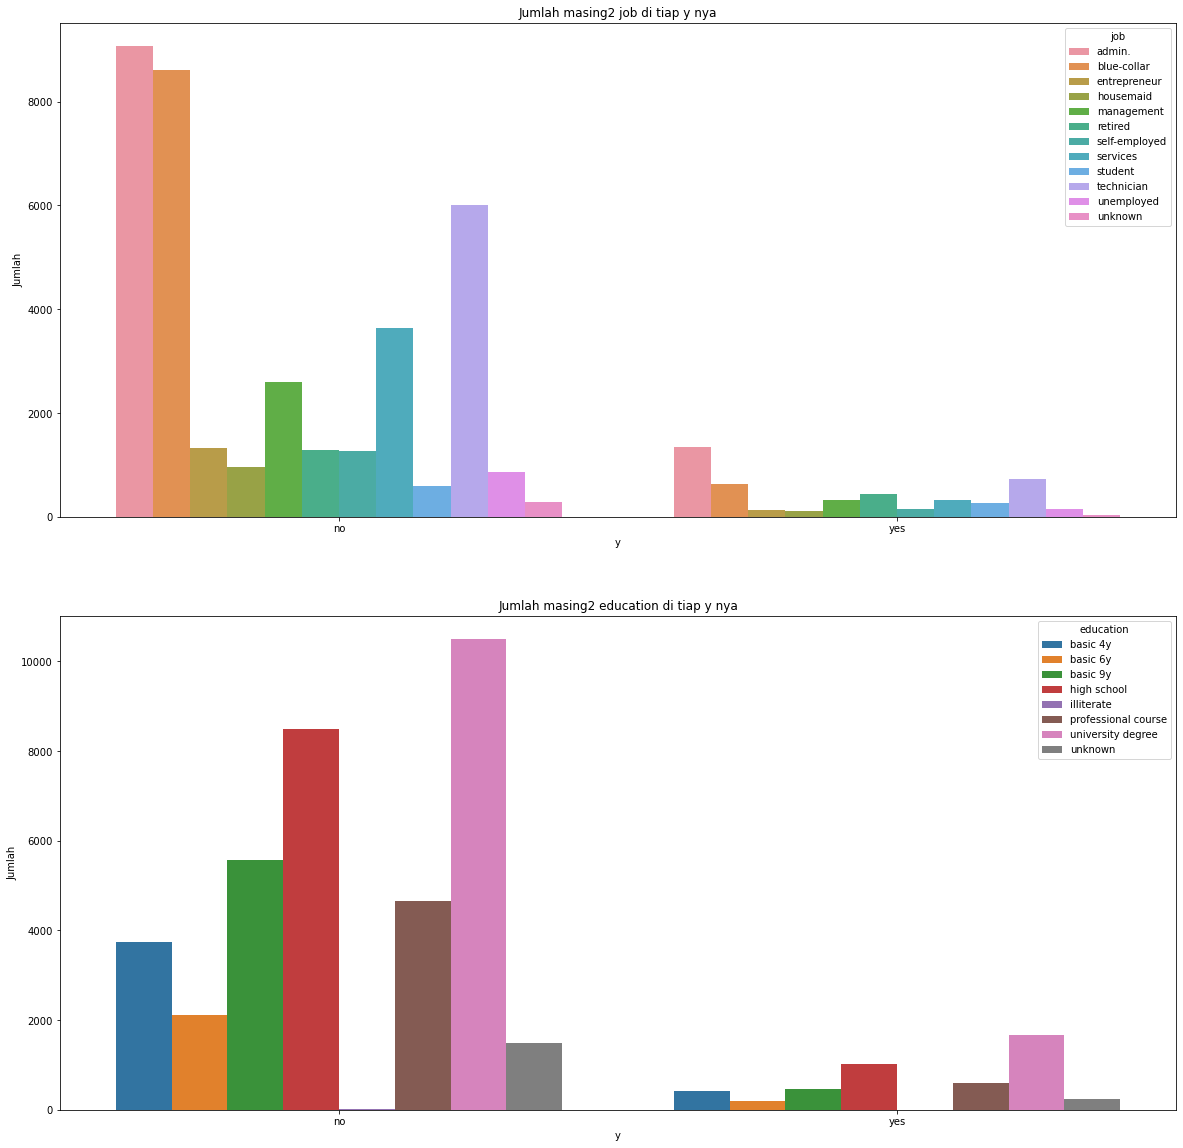

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(20, 20))
for i in cat_3: 
    bla3 = pd.crosstab(index=[df['y'], df[i]], columns='Jumlah')
    bla3 = bla3.reset_index()

    sns.barplot(ax = axes[cat_3.index(i)], x='y', y='Jumlah', data = bla3, hue=i)
    axes[(cat_3.index(i))].set_title('Jumlah masing2 ' + i + ' di tiap y nya')

# ML

### GOALS 

__Nurunin jumlah False Positif__ 

__Naikin Nilai Precision kelas 1 (YES)__

### PR

1. coba label encoder untuk categorical
2. coba di bin age, duration(per seratus, yng diatas 1000 jadi 1000++)

In [27]:
df_1 = df.drop(columns='duration')

In [28]:
df_1.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic 4y       no      no   no  telephone   
1   57   services  married  high school  unknown      no   no  telephone   
2   37   services  married  high school       no     yes   no  telephone   
3   40     admin.  married     basic 6y       no      no   no  telephone   
4   56   services  married  high school       no      no  yes  telephone   

  month day_of_week  campaign  pdays  previous     poutcome  emp.var.rate  \
0   may         mon         1    999         0  nonexistent           1.1   
1   may         mon         1    999         0  nonexistent           1.1   
2   may         mon         1    999         0  nonexistent           1.1   
3   may         mon         1    999         0  nonexistent           1.1   
4   may         mon         1    999         0  nonexistent           1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no

In [29]:
df_1['y'][df_1['y'] == 'no'] = 0
df_1['y'][df_1['y'] == 'yes'] = 1

In [30]:
df_1['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

In [31]:
df_1['y'] = df_1['y'].astype('int')

In [32]:
df_1['y'].dtypes

dtype('int32')

## Cek Imbalance Data

In [33]:
round(df_1['y'].value_counts()/len(df_1)*100, 2)

0    88.73
1    11.27
Name: y, dtype: float64

## Splitting Data

In [34]:
X = df_1.drop(columns='y')
y = df_1['y']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.20, random_state=42)

## Pipeline

In [36]:
num_columns = [i for i in num if i != 'duration']

cat_columns = [i for i in cat if i != 'y']

In [37]:
numeric_pipeline = Pipeline([
    ('scaler', RobustScaler()),
#     ('poly', PolynomialFeatures(degree=2, include_bias=False)),
#     ('power', PowerTransformer(method='yeo-johnson'))
])

categoric_pipeline = Pipeline([
    ('encoder', OneHotEncoder()) # coba pake label encoder (PR)
])

preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, num_columns),
    ('categorical', categoric_pipeline, cat_columns)
])

pipe_LR = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression())
])

pipe_KNN = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsClassifier())
])

pipe_SVM = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])

pipe_DT = Pipeline([
    ('prep', preprocessor),
    ('algo', DecisionTreeClassifier(random_state=42))
])

pipe_RF = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(random_state=42))
])

## Def Eva Metrix

Fungsi def yg isinya evaluation metrix.
Evaluation matrix yang dipakai kali ini adalah Cunfusion matrix dan Classification report

In [38]:
def conf_mat (Model, X_train, X_test, y_train, y_test,Nama):
    y_pred_test = Model.predict(X_test)
    cm_test = confusion_matrix(y_test, y_pred_test, labels=[1,0])
    df = pd.DataFrame(cm_test, index = ['Akt1', 'Akt0'], columns=['Pred1', 'Pred0'])
    print( 'Classification report data TEST ' + Nama + '\n\n', classification_report(y_test, y_pred_test))
    
    y_pred_train = Model.predict(X_train)
    print( 'Classification report data TRAIN ' + Nama + '\n\n', classification_report(y_train, y_pred_train))
#     return plt.title('Confusion matrix data test ' + Nama + '\n'), sns.heatmap(df, annot=True)
    print ('Confusion matrix data test ' + Nama + '\n')
    return df

## Over Sampling

Melakukan teknik Oversampling untuk mengatasa data imbalance sebelum modelling

In [39]:
df_train = pd.concat([X_train,y_train], axis=1)

In [40]:
df_train.head()

age           job   marital          education  default housing loan  \
25611   49   blue-collar   married           basic 9y  unknown      no   no   
26010   37  entrepreneur   married  university degree       no      no   no   
40194   78       retired   married           basic 4y       no      no   no   
297     36        admin.   married  university degree       no     yes   no   
36344   59       retired  divorced  university degree       no      no   no   

         contact month day_of_week  campaign  pdays  previous     poutcome  \
25611   cellular   nov         wed         4    999         0  nonexistent   
26010  telephone   nov         wed         2    999         1      failure   
40194   cellular   jul         mon         1    999         0  nonexistent   
297    telephone   may         mon         2    999         0  nonexistent   
36344   cellular   jun         tue         2    999         0  nonexistent   

       emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed  y  
25611          -0.1          93.200          -42.0      4.120       5195.8  0  
26010          -0.1          93.200          -42.0      4.120       5195.8  0  
40194          -1.7          94.215          -40.3      0.870       4991.6  1  
297             1.1          93.994          -36.4      4.857       5191.0  0  
36344          -2.9          92.963          -40.8      1.262       5076.2  0

In [41]:
df_train['y'].value_counts()

0    29238
1     3712
Name: y, dtype: int64

In [42]:
non_default = df_train[df_train['y'] == 0] # kelas majority

In [43]:
default = df_train[df_train['y'] == 1] # kelas minority

In [44]:
default_oversample = resample(default, 
                           replace = True, 
                           n_samples = len(non_default),
                           random_state=42)

In [45]:
df_OverSample= pd.concat([non_default, default_oversample])

In [46]:
df_OverSample['y'].value_counts()

1    29238
0    29238
Name: y, dtype: int64

In [47]:
X_train_OS = df_OverSample.drop(columns='y')
y_train_OS = df_OverSample['y']

## Modelling

__Logistic Regression__

In [48]:
pipe_LR.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital',
                                                   'education', 'default',
 

In [49]:
conf_mat(pipe_LR, X_train_OS, X_test, y_train_OS, y_test, 'LR Over Sampling')

Classification report data TEST LR Over Sampling

               precision    recall  f1-score   support

           0       0.95      0.84      0.89      7310
           1       0.35      0.66      0.45       928

    accuracy                           0.82      8238
   macro avg       0.65      0.75      0.67      8238
weighted avg       0.88      0.82      0.84      8238

Classification report data TRAIN LR Over Sampling

               precision    recall  f1-score   support

           0       0.69      0.84      0.76     29238
           1       0.80      0.63      0.70     29238

    accuracy                           0.73     58476
   macro avg       0.75      0.73      0.73     58476
weighted avg       0.75      0.73      0.73     58476

Confusion matrix data test LR Over Sampling



Pred1  Pred0
Akt1    608    320
Akt0   1154   6156

1 ==> Nasabah subscribe deposit (yes)

0 ==> Nasabah TIDAK subscribe deposit (no)

__KNN__

In [50]:
pipe_KNN.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital',
                                                   'education', 'default',
 

In [51]:
conf_mat(pipe_KNN, X_train_OS, X_test, y_train_OS, y_test, 'KNN Over Sampling')

Classification report data TEST KNN Over Sampling

               precision    recall  f1-score   support

           0       0.94      0.81      0.87      7310
           1       0.28      0.59      0.38       928

    accuracy                           0.78      8238
   macro avg       0.61      0.70      0.62      8238
weighted avg       0.86      0.78      0.81      8238

Classification report data TRAIN KNN Over Sampling

               precision    recall  f1-score   support

           0       1.00      0.85      0.92     29238
           1       0.87      1.00      0.93     29238

    accuracy                           0.93     58476
   macro avg       0.93      0.93      0.93     58476
weighted avg       0.93      0.93      0.93     58476

Confusion matrix data test KNN Over Sampling



Pred1  Pred0
Akt1    544    384
Akt0   1420   5890

__SVM__

In [52]:
pipe_SVM.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital',
                                                   'education', 'default',
 

In [53]:
conf_mat(pipe_SVM, X_train_OS, X_test, y_train_OS, y_test, 'SVM Over Sampling')

Classification report data TEST SVM Over Sampling

               precision    recall  f1-score   support

           0       0.35      0.01      0.03      7310
           1       0.09      0.80      0.17       928

    accuracy                           0.10      8238
   macro avg       0.22      0.41      0.10      8238
weighted avg       0.32      0.10      0.04      8238

Classification report data TRAIN SVM Over Sampling

               precision    recall  f1-score   support

           0       0.07      0.02      0.02     29238
           1       0.45      0.79      0.57     29238

    accuracy                           0.40     58476
   macro avg       0.26      0.40      0.30     58476
weighted avg       0.26      0.40      0.30     58476

Confusion matrix data test SVM Over Sampling



Pred1  Pred0
Akt1    741    187
Akt0   7208    102

__DT__

In [54]:
pipe_DT.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital',
                                                   'education', 'default',
 

In [55]:
conf_mat(pipe_DT, X_train_OS, X_test, y_train_OS, y_test, 'DT Over Sampling')

Classification report data TEST DT Over Sampling

               precision    recall  f1-score   support

           0       0.92      0.91      0.91      7310
           1       0.32      0.35      0.33       928

    accuracy                           0.84      8238
   macro avg       0.62      0.63      0.62      8238
weighted avg       0.85      0.84      0.85      8238

Classification report data TRAIN DT Over Sampling

               precision    recall  f1-score   support

           0       1.00      0.99      1.00     29238
           1       0.99      1.00      1.00     29238

    accuracy                           1.00     58476
   macro avg       1.00      1.00      1.00     58476
weighted avg       1.00      1.00      1.00     58476

Confusion matrix data test DT Over Sampling



Pred1  Pred0
Akt1    322    606
Akt0    681   6629

__RF__

In [56]:
pipe_RF.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital',
                                                   'education', 'default',
 

In [57]:
conf_mat(pipe_RF, X_train_OS, X_test, y_train_OS, y_test, 'RF Over Sampling')

Classification report data TEST RF Over Sampling

               precision    recall  f1-score   support

           0       0.93      0.95      0.94      7310
           1       0.49      0.40      0.44       928

    accuracy                           0.89      8238
   macro avg       0.71      0.67      0.69      8238
weighted avg       0.88      0.89      0.88      8238

Classification report data TRAIN RF Over Sampling

               precision    recall  f1-score   support

           0       1.00      0.99      1.00     29238
           1       0.99      1.00      1.00     29238

    accuracy                           1.00     58476
   macro avg       1.00      1.00      1.00     58476
weighted avg       1.00      1.00      1.00     58476

Confusion matrix data test RF Over Sampling



Pred1  Pred0
Akt1    372    556
Akt0    381   6929

_____________

## HYPERPARAMETER TUNING

In [58]:
skf = StratifiedKFold(n_splits=3)

https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

In [59]:
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score)
}

========================

__LR__

========================

In [60]:
param_LR = {
    'algo__C' : list(np.logspace(-4,1,10)) + [1.0],
    'algo__class_weight' : [None, {0:.4, 1:.6}, {0:.3, 1:.7}, {0:.2, 1:.8}, {0:.1, 1:.9}],
    'algo__fit_intercept' : [False, True],
    'algo__penalty' : ['l1', 'l2', 'elasticnet', 'none']
}

In [61]:
LR_GS = GridSearchCV(pipe_LR, param_LR, cv = skf, n_jobs=-1, verbose =1, scoring=scorers, refit='recall_score', return_train_score=True)

In [62]:
LR_GS.fit(X_train_OS, y_train_OS)

Fitting 3 folds for each of 440 candidates, totalling 1320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1320 out of 1320 | elapsed:  4.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('scaler',
                                                                                          RobustScaler())]),
                                                                         ['age',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous',
                                                                          'emp.var.rate',
                                                                          'cons.price.idx',
                                                              

In [63]:
LR_GS.best_params_

{'algo__C': 0.0001,
 'algo__class_weight': {0: 0.2, 1: 0.8},
 'algo__fit_intercept': False,
 'algo__penalty': 'l2'}

In [64]:
pd.DataFrame(LR_GS.cv_results_).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_algo__C', 'param_algo__class_weight',
       'param_algo__fit_intercept', 'param_algo__penalty', 'params',
       'split0_test_precision_score', 'split1_test_precision_score',
       'split2_test_precision_score', 'mean_test_precision_score',
       'std_test_precision_score', 'rank_test_precision_score',
       'split0_train_precision_score', 'split1_train_precision_score',
       'split2_train_precision_score', 'mean_train_precision_score',
       'std_train_precision_score', 'split0_test_recall_score',
       'split1_test_recall_score', 'split2_test_recall_score',
       'mean_test_recall_score', 'std_test_recall_score',
       'rank_test_recall_score', 'split0_train_recall_score',
       'split1_train_recall_score', 'split2_train_recall_score',
       'mean_train_recall_score', 'std_train_recall_score'],
      dtype='object')

In [88]:
tab_hyper_LR = pd.DataFrame(LR_GS.cv_results_)[['param_algo__C', 'param_algo__class_weight', 'param_algo__fit_intercept', 'param_algo__penalty', 'mean_test_recall_score', 'mean_test_precision_score']]
tab_hyper_LR = (tab_hyper_LR.sort_values(by=['mean_test_recall_score', 'mean_test_precision_score'], ascending=False).reset_index()).drop(columns='index')
tab_hyper_LR[(tab_hyper_LR['mean_test_recall_score'] > 0.7) & (tab_hyper_LR['mean_test_precision_score'] > 0.7)]

param_algo__C param_algo__class_weight param_algo__fit_intercept  \
138    0.00464159         {0: 0.4, 1: 0.6}                      True   
139    0.00464159         {0: 0.4, 1: 0.6}                     False   
140       2.78256         {0: 0.4, 1: 0.6}                     False   
141      0.774264         {0: 0.4, 1: 0.6}                      True   
142      0.016681         {0: 0.4, 1: 0.6}                      True   
143      0.016681         {0: 0.4, 1: 0.6}                     False   
144            10         {0: 0.4, 1: 0.6}                      True   
145      0.215443         {0: 0.4, 1: 0.6}                      True   
146        0.0001         {0: 0.4, 1: 0.6}                      True   
147   0.000359381         {0: 0.4, 1: 0.6}                      True   
148    0.00129155         {0: 0.4, 1: 0.6}                      True   
149    0.00464159         {0: 0.4, 1: 0.6}                      True   
150      0.016681         {0: 0.4, 1: 0.6}                      True   
151     0.0599484         {0: 0.4, 1: 0.6}                      True   
152      0.215443         {0: 0.4, 1: 0.6}                      True   
153      0.774264         {0: 0.4, 1: 0.6}                      True   
154       2.78256         {0: 0.4, 1: 0.6}                      True   
155            10         {0: 0.4, 1: 0.6}                      True   
156             1         {0: 0.4, 1: 0.6}                      True   
157            10         {0: 0.4, 1: 0.6}                     False   
158             1         {0: 0.4, 1: 0.6}                     False   
159     0.0599484         {0: 0.4, 1: 0.6}                      True   
160      0.215443         {0: 0.4, 1: 0.6}                     False   

    param_algo__penalty  mean_test_recall_score  mean_test_precision_score  
138                  l2                0.714755                   0.719432  
139                  l2                0.713079                   0.721392  
140                  l2                0.707162                   0.729776  
141                  l2                0.706444                   0.729456  
142                  l2                0.706136                   0.731718  
143                  l2                0.705383                   0.731483  
144                  l2                0.704221                   0.732975  
145                  l2                0.704084                   0.731296  
146                none                0.703400                   0.735079  
147                none                0.703400                   0.735079  
148                none                0.703400                   0.735079  
149                none                0.703400                   0.735079  
150                none                0.703400                   0.735079  
151                none                0.703400                   0.735079  
152                none                0.703400                   0.735079  
153                none                0.703400                   0.735079  
154                none                0.703400                   0.735079  
155                none                0.703400                   0.735079  
156                none                0.703400                   0.735079  
157                  l2                0.701587                   0.734997  
158                  l2                0.701279                   0.734684  
159                  l2                0.701142                   0.735575  
160                  l2                0.700527                   0.735586

______________
_UNTUK yng best estimator_
_____________

In [66]:
LR_Tune = LR_GS.best_estimator_

In [67]:
LR_Tune.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital',
                                                   'education', 'default',
 

In [68]:
conf_mat(LR_Tune, X_train_OS, X_test, y_train_OS, y_test, 'LR Tuning best estimator')

Classification report data TEST LR Tuning best estimator

               precision    recall  f1-score   support

           0       1.00      0.00      0.01      7310
           1       0.11      1.00      0.20       928

    accuracy                           0.12      8238
   macro avg       0.56      0.50      0.10      8238
weighted avg       0.90      0.12      0.03      8238

Classification report data TRAIN LR Tuning best estimator

               precision    recall  f1-score   support

           0       0.86      0.00      0.00     29238
           1       0.50      1.00      0.67     29238

    accuracy                           0.50     58476
   macro avg       0.68      0.50      0.34     58476
weighted avg       0.68      0.50      0.34     58476

Confusion matrix data test LR Tuning best estimator



Pred1  Pred0
Akt1    928      0
Akt0   7289     21

______________
_{
    'algo__C' : 0.00464159,
    'algo__class_weight' : {0: 0.4, 1: 0.6},
    'algo__fit_intercept' : True,
    'algo__penalty' : l2
}_
_____________

In [69]:
pipe_LR_1 = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(C=0.00464159, class_weight={0:0.4, 1:0.6}, fit_intercept=True, penalty='l2'))
])

In [70]:
pipe_LR_1.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital',
                                                   'education', 'default',
 

In [71]:
conf_mat(pipe_LR_1, X_train_OS, X_test, y_train_OS, y_test, 'LR Tuning 1')

Classification report data TEST LR Tuning 1

               precision    recall  f1-score   support

           0       0.96      0.73      0.83      7310
           1       0.26      0.74      0.38       928

    accuracy                           0.73      8238
   macro avg       0.61      0.73      0.60      8238
weighted avg       0.88      0.73      0.78      8238

Classification report data TRAIN LR Tuning 1

               precision    recall  f1-score   support

           0       0.72      0.72      0.72     29238
           1       0.72      0.72      0.72     29238

    accuracy                           0.72     58476
   macro avg       0.72      0.72      0.72     58476
weighted avg       0.72      0.72      0.72     58476

Confusion matrix data test LR Tuning 1



Pred1  Pred0
Akt1    688    240
Akt0   2002   5308

______________
_{
    'algo__C' : 0.0001,
    'algo__class_weight' : {0: 0.4, 1: 0.6},
    'algo__fit_intercept' : False,
    'algo__penalty' : l2
}_
_____________

In [72]:
pipe_LR_2 = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(C=0.0001, class_weight={0:0.4, 1:0.6}, fit_intercept=False, penalty='l2'))
])

In [73]:
pipe_LR_2.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital',
                                                   'education', 'default',
 

In [74]:
conf_mat(pipe_LR_2, X_train_OS, X_test, y_train_OS, y_test, 'LR Tuning 2')

Classification report data TEST LR Tuning 2

               precision    recall  f1-score   support

           0       0.96      0.53      0.69      7310
           1       0.18      0.81      0.30       928

    accuracy                           0.57      8238
   macro avg       0.57      0.67      0.49      8238
weighted avg       0.87      0.57      0.64      8238

Classification report data TRAIN LR Tuning 2

               precision    recall  f1-score   support

           0       0.73      0.54      0.62     29238
           1       0.63      0.80      0.71     29238

    accuracy                           0.67     58476
   macro avg       0.68      0.67      0.66     58476
weighted avg       0.68      0.67      0.66     58476

Confusion matrix data test LR Tuning 2



Pred1  Pred0
Akt1    752    176
Akt0   3407   3903

========================

__SVM__

========================

In [75]:
# pipe_SVM.get_params()

In [76]:
param_SVM = {
    'algo__C' : list(np.logspace(-4,1,10)) + [1.0],
    'algo__class_weight' : [None, {0:.4, 1:.6}, {0:.3, 1:.7}, {0:.2, 1:.8}, {0:.1, 1:.9}],
    'algo__gamma' : [1, 0.1, 0.01, 0.001, 0.0001, 'scale'],
    'algo__kernel' : ['linear', 'poly', 'rbf']
}

In [77]:
SVM_RS = RandomizedSearchCV(pipe_SVM, param_SVM, cv = skf, n_iter=200, n_jobs=-1, verbose =1, random_state=42, scoring=scorers, refit='recall_score', return_train_score=True)

In [78]:
SVM_RS.fit(X_train_OS, y_train_OS)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 16.8min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('scaler',
                                                                                                RobustScaler())]),
                                                                               ['age',
                                                                                'campaign',
                                                                                'pdays',
                                                                                'previous',
                                                                                'emp.var.rate',
                                                                                'cons.price.id

In [79]:
SVM_RS.best_params_

{'algo__kernel': 'poly',
 'algo__gamma': 'scale',
 'algo__class_weight': {0: 0.1, 1: 0.9},
 'algo__C': 0.0001}

In [80]:
pd.DataFrame(SVM_RS.cv_results_).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_algo__kernel', 'param_algo__gamma', 'param_algo__class_weight',
       'param_algo__C', 'params', 'split0_test_precision_score',
       'split1_test_precision_score', 'split2_test_precision_score',
       'mean_test_precision_score', 'std_test_precision_score',
       'rank_test_precision_score', 'split0_train_precision_score',
       'split1_train_precision_score', 'split2_train_precision_score',
       'mean_train_precision_score', 'std_train_precision_score',
       'split0_test_recall_score', 'split1_test_recall_score',
       'split2_test_recall_score', 'mean_test_recall_score',
       'std_test_recall_score', 'rank_test_recall_score',
       'split0_train_recall_score', 'split1_train_recall_score',
       'split2_train_recall_score', 'mean_train_recall_score',
       'std_train_recall_score'],
      dtype='object')

In [81]:
tab_hyper_SVM = pd.DataFrame(SVM_RS.cv_results_)[['param_algo__C', 'param_algo__class_weight', 'param_algo__gamma', 'param_algo__kernel', 'mean_test_recall_score', 'mean_test_precision_score']]
tab_hyper_SVM = (tab_hyper_SVM.sort_values(by=['mean_test_recall_score', 'mean_test_precision_score'], ascending=False).reset_index()).drop(columns='index')
tab_hyper_SVM[(tab_hyper_SVM['mean_test_recall_score'] > 0.9) & (tab_hyper_SVM['mean_test_precision_score'] > 0.49)]

param_algo__C param_algo__class_weight param_algo__gamma  \
0       0.215443         {0: 0.1, 1: 0.9}              0.01   
1       0.215443         {0: 0.1, 1: 0.9}             0.001   
2       0.016681         {0: 0.4, 1: 0.6}                 1   
3        2.78256         {0: 0.3, 1: 0.7}               0.1   
4         0.0001         {0: 0.1, 1: 0.9}             scale   
..           ...                      ...               ...   
76      0.215443         {0: 0.3, 1: 0.7}             scale   
77      0.215443         {0: 0.3, 1: 0.7}             0.001   
78      0.215443         {0: 0.3, 1: 0.7}            0.0001   
79             1         {0: 0.2, 1: 0.8}             0.001   
82      0.016681         {0: 0.1, 1: 0.9}                 1   

   param_algo__kernel  mean_test_recall_score  mean_test_precision_score  
0              linear                1.000000                   0.500180  
1              linear                1.000000                   0.500180  
2                 rbf                1.000000                   0.500034  
3                 rbf                1.000000                   0.500009  
4                poly                1.000000                   0.500000  
..                ...                     ...                        ...  
76             linear                0.997298                   0.499837  
77             linear                0.997298                   0.499837  
78             linear                0.997298                   0.499837  
79             linear                0.972809                   0.502829  
82               poly                0.939804                   0.493012  

[81 rows x 6 columns]

______________
_UNTUK yng best estimator_
_____________

In [82]:
SVM_Tune = SVM_RS.best_estimator_

In [83]:
SVM_Tune.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital',
                                                   'education', 'default',
 

In [84]:
conf_mat(SVM_Tune, X_train_OS, X_test, y_train_OS, y_test, 'SVM Tuning best estimator')

Classification report data TEST SVM Tuning best estimator

               precision    recall  f1-score   support

           0       0.00      0.00      0.00      7310
           1       0.11      1.00      0.20       928

    accuracy                           0.11      8238
   macro avg       0.06      0.50      0.10      8238
weighted avg       0.01      0.11      0.02      8238

Classification report data TRAIN SVM Tuning best estimator

               precision    recall  f1-score   support

           0       0.00      0.00      0.00     29238
           1       0.50      1.00      0.67     29238

    accuracy                           0.50     58476
   macro avg       0.25      0.50      0.33     58476
weighted avg       0.25      0.50      0.33     58476

Confusion matrix data test SVM Tuning best estimator



Pred1  Pred0
Akt1    928      0
Akt0   7310      0

______________
_{
    'algo__C' : 0.016681,
    'algo__class_weight' : {0: 0.1, 1: 0.9},
    'algo__gamma' : 1,
    'algo__kernel' : poly
}_
_____________

In [85]:
pipe_SVM_1 = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(C=0.0016681, class_weight={0:0.1, 1:0.9}, gamma=1, kernel='poly', max_iter=500))
])

In [86]:
pipe_SVM_1.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital',
                                                   'education', 'default',
 

In [87]:
conf_mat(pipe_SVM_1, X_train_OS, X_test, y_train_OS, y_test, 'SVM Tuning 1')

Classification report data TEST SVM Tuning 1

               precision    recall  f1-score   support

           0       0.39      0.02      0.03      7310
           1       0.09      0.80      0.17       928

    accuracy                           0.10      8238
   macro avg       0.24      0.41      0.10      8238
weighted avg       0.36      0.10      0.05      8238

Classification report data TRAIN SVM Tuning 1

               precision    recall  f1-score   support

           0       0.08      0.02      0.03     29238
           1       0.45      0.79      0.57     29238

    accuracy                           0.40     58476
   macro avg       0.26      0.40      0.30     58476
weighted avg       0.26      0.40      0.30     58476

Confusion matrix data test SVM Tuning 1



Pred1  Pred0
Akt1    741    187
Akt0   7189    121